# Network Training
Having implemented and tested all the components of the final networks in steps 1-3, we are now ready to train the network on a large dataset (ImageNet).

In [1]:
import os
import gc
import datetime

import pandas as pd
import numpy as np

from copy import deepcopy
from tqdm import tqdm

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import TensorBoard
from keras import backend as K

import cv2
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
from IPython.display import clear_output

from libs.pconv_model import PConvUnet
from libs.util import random_mask, single_rect_mask

%load_ext autoreload
%autoreload 2
plt.ioff()

# SETTINGS
TRAIN_DIR = r"D:\Documents\Kaggle\Kaggle-imagenet\input\DET\train\ILSVRC2013_train\\"
TEST_DIR = r"D:\Documents\Kaggle\Kaggle-imagenet\input\DET\pexels\\"
VAL_DIR = r"D:\Documents\Kaggle\Kaggle-imagenet\input\DET\val\val_100\\"\
    
TRAIN_DIR = "/home/srihari/Projects/PConv-Keras/data/train"
TEST_DIR = "/home/srihari/Projects/PConv-Keras/data/test"
VAL_DIR = "/home/srihari/Projects/PConv-Keras/data/val"


MODEL_WEIGHT_PATH = "/home/srihari/Projects/PConv-Keras/model"


BATCH_SIZE = 4

IMG_TARGET_SIZE = (256, 256)


TENSORBOARD_LOG_DIR = "/home/srihari/Projects/PConv-Keras/logs"

Using TensorFlow backend.


# Creating train & test data generator

In [2]:
class DataGenerator(ImageDataGenerator):
    def flow_from_directory(self, directory, *args, **kwargs):
        print(directory)
        generator = super().flow_from_directory(directory, class_mode=None, *args, **kwargs)
        while True:
            
            # Get augmentend image samples
            ori = next(generator)

            # Get masks for each image sample
            # mask = np.stack([random_mask(ori.shape[1], ori.shape[2]) for _ in range(ori.shape[0])], axis=0)
            
            # Get masks for each image sample
            mask = np.stack([single_rect_mask(ori.shape[1], ori.shape[2], ori.shape[3], 
                                              max_rh=30, max_rw=30, 
                                              min_rh=25, min_rw=25) 
                             for _ in range(ori.shape[0])], axis=0)

            # Apply masks to all image sample
            masked = deepcopy(ori)
            masked[mask==0] = 1

            # Yield ([ori, masl],  ori) training batches
            # print(masked.shape, ori.shape)
            gc.collect()
            yield [masked, mask], ori
            
# Create training generator
train_datagen = DataGenerator(  
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rescale=1./255,
    horizontal_flip=True
)
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR, target_size=IMG_TARGET_SIZE, batch_size=BATCH_SIZE
)

# Create validation generator
val_datagen = DataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(
    VAL_DIR, target_size=IMG_TARGET_SIZE, batch_size=BATCH_SIZE, seed=1
)

# Create testing generator
test_datagen = DataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    TEST_DIR, target_size=IMG_TARGET_SIZE, batch_size=BATCH_SIZE, seed=1
)

/home/srihari/Projects/PConv-Keras/data/test
Found 1000 images belonging to 1 classes.


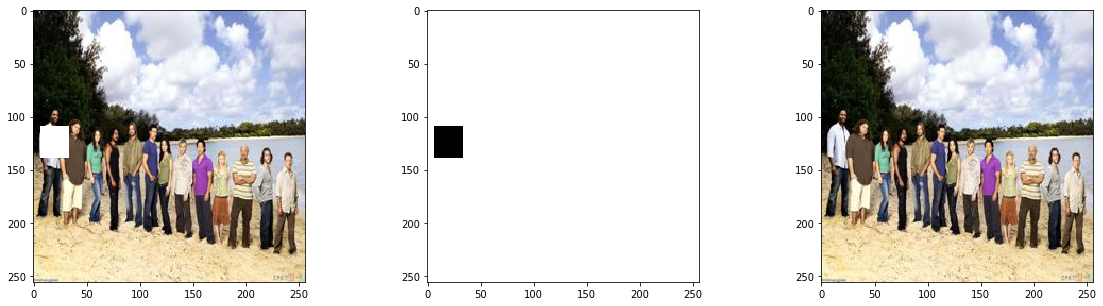

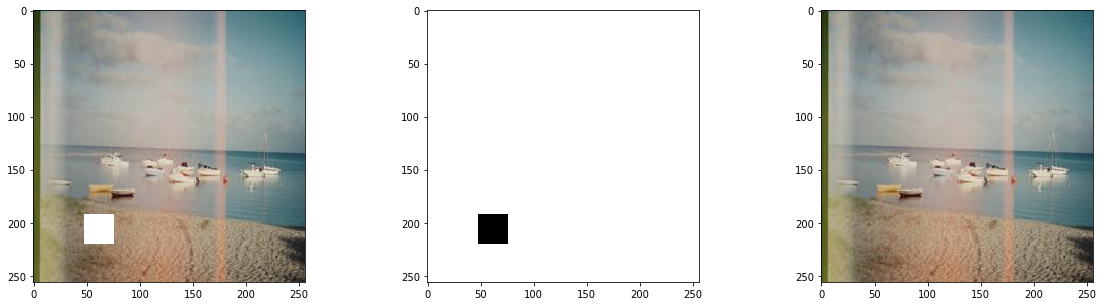

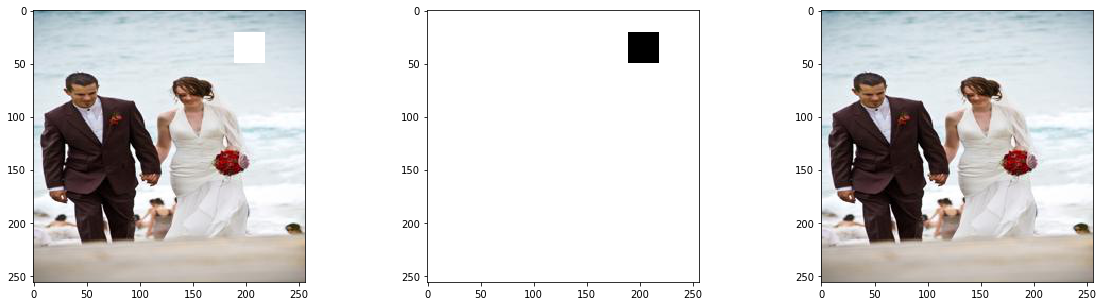

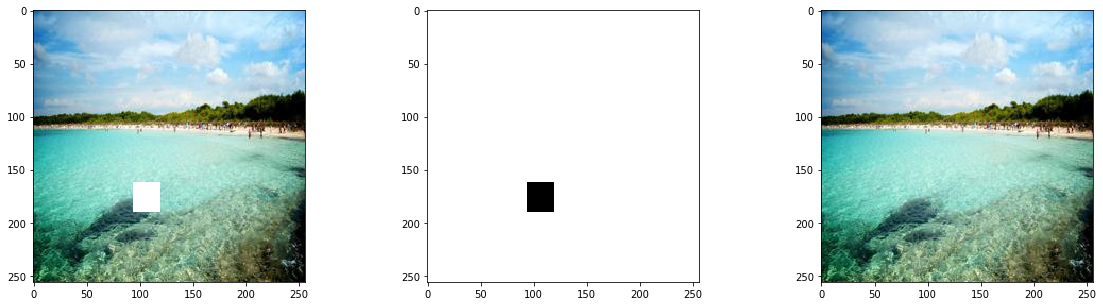

In [3]:
# Pick out an example
test_data = next(test_generator)
(masked, mask), ori = test_data

# Show side by side
for i in range(len(ori)):
    _, axes = plt.subplots(1, 3, figsize=(20, 5))
    axes[0].imshow(masked[i,:,:,:])
    axes[1].imshow(mask[i,:,:,:] * 1.)
    axes[2].imshow(ori[i,:,:,:])
    plt.show()

# Training on Places365

In [4]:
def plot_callback(model):
    """Called at the end of each epoch, displaying our previous test images,
    as well as their masked predictions and saving them to disk"""
    
    # Get samples & Display them        
    pred_img = model.predict([masked, mask])
    pred_time = datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S')

    # Clear current output and display test images
    for i in range(len(ori)):
        _, axes = plt.subplots(1, 3, figsize=(20, 5))
        axes[0].imshow(masked[i,:,:,:])
        axes[1].imshow(pred_img[i,:,:,:] * 1.)
        axes[2].imshow(ori[i,:,:,:])
        axes[0].set_title('Masked Image')
        axes[1].set_title('Predicted Image')
        axes[2].set_title('Original Image')
                
        plt.savefig(r'./data/test_samples/img_{}_{}.png'.format(i, pred_time))
        plt.close()

## Phase 1 - with batch normalization

In [7]:
# Instantiate the model
# model = PConvUnet(weight_filepath='data/logs/')
# model.load(r"C:\Users\MAFG\Documents\Github-Public\PConv-Keras\data\logs\50_weights_2018-06-01-16-41-43.h5")

In [7]:
model = PConvUnet(weight_filepath=MODEL_WEIGHT_PATH)


In [9]:
# Run training for certain amount of epochs
# model.fit(
#     train_generator, 
#     steps_per_epoch=10000,
#     validation_data=val_generator,
#     validation_steps=100,
#     epochs=50,        
#     plot_callback=plot_callback,
#     callbacks=[
#         TensorBoard(log_dir='../data/logs/initial_training', write_graph=False)
#     ]
# )


model.fit(
    train_generator, 
    steps_per_epoch=100,
    validation_data=val_generator,
    validation_steps=100,
    epochs=50,        
    plot_callback=plot_callback,
    callbacks=[
        TensorBoard(log_dir=TENSORBOARD_LOG_DIR, write_graph=False)
    ]
)

Epoch 1/1
100/100 [==============================] - 297s 3s/step - loss: 360844.8414 - val_loss: 319424.2219
Epoch 2/2
100/100 [==============================] - 297s 3s/step - loss: 230877.7505 - val_loss: 247386.4216
Epoch 3/3
100/100 [==============================] - 296s 3s/step - loss: 192940.1027 - val_loss: 198517.4445
Epoch 4/4
100/100 [==============================] - 296s 3s/step - loss: 172611.4667 - val_loss: 198957.6222
Epoch 5/5
100/100 [==============================] - 296s 3s/step - loss: 161738.1335 - val_loss: 183320.2503
Epoch 6/6
100/100 [==============================] - 299s 3s/step - loss: 156200.8859 - val_loss: 166393.8180
Epoch 7/7
100/100 [==============================] - 296s 3s/step - loss: 143802.6910 - val_loss: 156850.8505
Epoch 8/8
100/100 [==============================] - 299s 3s/step - loss: 144608.9666 - val_loss: 146075.0144
Epoch 9/9
100/100 [==============================] - 298s 3s/step - loss: 136768.8509 - val_loss: 169041.5010
Epoch 10/1

## Phase 2 - without batch normalization

In [5]:
# Load weights from previous run
model = PConvUnet(weight_filepath=MODEL_WEIGHT_PATH)
model.load(
    r"/home/srihari/Projects/PConv-Keras/model/55_weights_2019-01-05-19-35-51.h5",
    train_bn=False,
    lr=0.00005
)

In [ ]:
# Run training for certain amount of epochs
model.fit(
    train_generator, 
    use_multiprocessing=True, # Srihari
    steps_per_epoch=250,
    validation_data=val_generator,
    validation_steps=100,
    epochs=10,        
    workers=3,
    plot_callback=plot_callback,
    callbacks=[
        TensorBoard(log_dir=os.path.join(TENSORBOARD_LOG_DIR, 'fine_tuning'), write_graph=False)
    ]
)

/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 56/56
/home/srihari/Projects/PConv-Keras/data/train
/home/srihari/Projects/PConv-Keras/data/train
/home/srihari/Projects/PConv-Keras/data/train
/home/srihari/Projects/PConv-Keras/data/val
/home/srihari/Projects/PConv-Keras/data/val
/home/srihari/Projects/PConv-Keras/data/val
Found 1000 images belonging to 1 classes.
Found 1000 images belonging to 1 classes.
Found 1000 images belonging to 1 classes.
Found 3499 images belonging to 1 classes.
Found 3499 images belonging to 1 classes.
Found 3499 images belonging to 1 classes.
150/250 [=================>............] - ETA: 3:29 - loss: 70352.4509

## Phase 3 - Generating samples

In [5]:
# Load weights from previous run
model = PConvUnet(weight_filepath='data/logs/')
model.load(
    r"/home/srihari/Projects/PConv-Keras/55_weights_2019-01-05-19-35-51.h5",
    train_bn=False,
    lr=0.00005
)

In [6]:
n = 0
for (masked, mask), ori in tqdm(test_generator):
    
    # Run predictions for this batch of images
    pred_img = model.predict([masked, mask])
    pred_time = datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S')
    
    # Clear current output and display test images
    for i in range(len(ori)):
        _, axes = plt.subplots(1, 2, figsize=(10, 5))
        axes[0].imshow(masked[i,:,:,:])
        axes[1].imshow(pred_img[i,:,:,:] * 1.)
        axes[0].set_title('Masked Image')
        axes[1].set_title('Predicted Image')
        axes[0].xaxis.set_major_formatter(NullFormatter())
        axes[0].yaxis.set_major_formatter(NullFormatter())
        axes[1].xaxis.set_major_formatter(NullFormatter())
        axes[1].yaxis.set_major_formatter(NullFormatter())
                
        plt.savefig(r'data/test_samples/img_{}_{}.png'.format(i, pred_time))
        plt.close()
        n += 1
        
    # Only create predictions for about 100 images
    if n > 10:
        break

0it [00:00, ?it/s]

/home/srihari/Projects/PConv-Keras/data/test
Found 1000 images belonging to 1 classes.


2it [00:04,  2.79s/it]
